In [1]:
import os
import numpy as np
import pandas as pd

import ivfunctions_nested 
import mliv.dgps_nested as dgps
import matplotlib.pyplot as plt

from mliv.rkhs import RKHSIV, ApproxRKHSIVCV, RKHSIVCV, RKHSIVL2CV, RKHSIVL2, RKHS2IVCV, RKHS2IV, RKHSIVL2CV, RKHS2IV


 

ImportError: cannot import name 'RKHS2IVL2CV' from 'mliv.rkhs' (c:\users\isaac\dropbox\repos\nnpiv\mliv\rkhs\__init__.py)

In [ ]:
fn_number = 15
tau_fn = dgps.get_tau_fn(fn_number)

In [ ]:
A, D, B, C, Y, tau_fn = dgps.get_data(3000, 10, 10, tau_fn, 2)


B_test = np.zeros((1000, B.shape[1]))
B_test += np.median(B, axis=0, keepdims=True)
B_test[:, 0] = np.linspace(np.percentile(B[:, 0], 5), np.percentile(B[:, 0], 95), 1000)

B_test = B_test[np.argsort(B_test[:, 0])]
true_fn = tau_fn(B_test)


In [ ]:
def nested_npivfit(A, B, C, D, Y, B_test, model, fitargs=None):
    
    B1_test = B_test
    Y = Y
    A1 = A
    B1 = B
    A2 = D
    B2 = C

    #First stage
    if fitargs is not None:
        model.fit(A2, A1, Y, **fitargs)
    else:
        model.fit(A2, A1, Y)
    bridge_fs = model.predict(A1)
    bridge_fs = bridge_fs.reshape(A1.shape[:1] + Y.shape[1:])

    #Second stage
    if fitargs is not None:
        model.fit(B2, B1, bridge_fs, **fitargs)
    else:
        model.fit(B2, B1, bridge_fs)
    
    y_pred = model.predict(B1_test)
    return y_pred.reshape(B1_test.shape[:1] + Y.shape[1:])





In [ ]:
approxrkhs_model = ApproxRKHSIVCV(kernel_approx='nystrom', n_components=200,
                           kernel='rbf', gamma=.1, delta_scale='auto',
                           delta_exp=.4, alpha_scales=np.geomspace(1, 10000, 10), cv=5)

approxrkhs_pred = nested_npivfit(A, B, C, D, Y, B_test, model=approxrkhs_model)



In [ ]:
rkhs_model = RKHSIV(kernel='rbf', gamma=.1, delta_scale='auto', delta_exp=.4)
rkhs_pred = nested_npivfit(A, B, C, D, Y, B_test, model=rkhs_model)

In [ ]:
rkhs_model = RKHSIV(kernel='rbf', gamma=.1, delta_scale='auto', delta_exp=.4)
#rkhs_pred = nested_npivfit(A, B, C, D, Y, B_test, model=rkhs_model)

In [ ]:
rkhsl2_model = RKHSIVL2(kernel='rbf', gamma=.1, delta_scale='auto')
#rkhsl2_pred = nested_npivfit(A, B, C, D, Y, B_test, model=rkhsl2_model)

In [ ]:
rkhsl2cv_model = RKHSIVL2CV(kernel='rbf', gamma=.1, delta_scale='auto', alpha_scales=np.geomspace(1, 10000, 10), cv=5)
#rkhsl2cv_pred = nested_npivfit(A, B, C, D, Y, B_test, model=rkhsl2cv_model)

In [ ]:
rkhs2_model = RKHS2IV(kernel='rbf', gamma=.1, delta_scale='auto', delta_exp=.4)
rkhs2_pred = rkhs2_model.fit(A, B, C, D, Y).predict(B_test)


In [ ]:
rkhs2cv_model = RKHS2IVCV(kernel='rbf', gamma=.1, delta_scale='auto', delta_exp=.4, alpha_scales=np.geomspace(1, 10000, 10), cv=5)
#rkhs2cv_pred = rkhs2cv_model.fit(A, B, C, D, Y).predict(B_test)

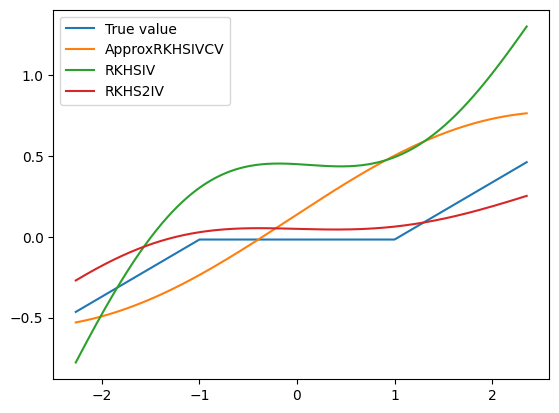

In [ ]:
plt.plot(B_test[:, 0], true_fn, label='True value')
plt.plot(B_test[:, 0], approxrkhs_pred, label='ApproxRKHSIVCV')
plt.plot(B_test[:, 0], rkhs_pred, label='RKHSIV')
#plt.plot(B_test[:, 0], rkhs_pred, label='RKHSIV')
#plt.plot(B_test[:, 0], rkhsl2_pred, label='RKHSIVL2')
#plt.plot(B_test[:, 0], rkhsl2cv_pred, label='RKHSIVL2CV')
plt.plot(B_test[:, 0], rkhs2_pred, label='RKHS2IV')
#plt.plot(B_test[:, 0], rkhs2cv_pred, label='RKHS2IVCV')
plt.legend()